<a href="https://colab.research.google.com/github/zeyad-mohvme-d/-Sign-Language-Fingerspelling-Assistant-ASL-Alphabet-/blob/main/ASL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import os

In [4]:
import kagglehub

path = kagglehub.dataset_download("grassknoted/asl-alphabet")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'asl-alphabet' dataset.
Path to dataset files: /kaggle/input/asl-alphabet


In [99]:
path = "/kaggle/input/asl-alphabet"

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(path, "asl_alphabet_train/asl_alphabet_train"),
    validation_split = 0.1,
    subset = "training",
    seed = 123,
    shuffle = True,
    image_size = (128, 128),
    batch_size = 32
)


val_data = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(path, "asl_alphabet_train", "asl_alphabet_train"),
    validation_split=0.1,
    subset="validation",
    seed=123,
    shuffle = True,
    image_size=(128, 128),
    batch_size=32

)

Found 87000 files belonging to 29 classes.
Using 78300 files for training.
Found 87000 files belonging to 29 classes.
Using 8700 files for validation.


In [66]:
type(train_data)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [6]:
len(train_data)

2447

In [7]:
clas_names = train_data.class_names
clas_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [8]:
m = {}

for i in range(26):
    m[chr(ord('A') + i)] = i

m["nothing"] = 27
m["space"] = 28

In [9]:
test_data = []
test_labels = []

test_path = os.path.join(path, "asl_alphabet_test", "asl_alphabet_test")
image_size = (128, 128)


for filename in os.listdir(test_path):
  img_path = os.path.join(test_path, filename)
  char = filename.split("_")[0]
  test_labels.append(m[char])
  img = load_img(img_path, target_size=image_size)
  img_array = img_to_array(img)
  test_data.append(img_array)




print(test_data[0].shape)
print(test_labels)


test_data = np.array(test_data)
test_labels = np.array(test_labels)




(128, 128, 3)
[0, 4, 11, 13, 18, 3, 6, 8, 22, 12, 27, 23, 7, 16, 2, 19, 15, 21, 24, 20, 28, 14, 1, 17, 5, 25, 9, 10]


In [71]:
images, labels = next(iter(train_data))

images = images.numpy()
labels = labels.numpy()


In [81]:
from tensorflow.keras.layers import RandomRotation, RandomBrightness, RandomZoom, RandomContrast, Rescaling



data_Augmentation  = tf.keras.Sequential([
    Rescaling(1./255),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

In [82]:
aug = data_Augmentation(images)

type(aug)

In [90]:
print(type(images))      # هل NumPy array ولا Tensor؟
print(images.dtype)      # float32, uint8, إلخ
print(images.shape)      # شكل الصور (batch, height, width, channels)
print(np.min(images), np.max(images))

<class 'numpy.ndarray'>
float32
(32, 128, 128, 3)
0.0 255.0


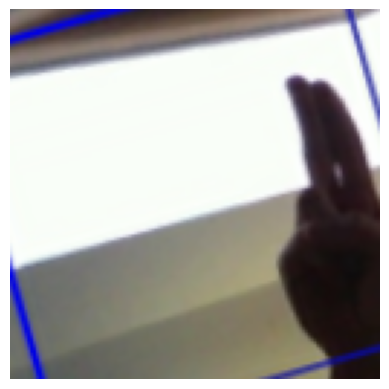

In [88]:
plt.imshow(aug[4])
plt.axis('off')
plt.show()

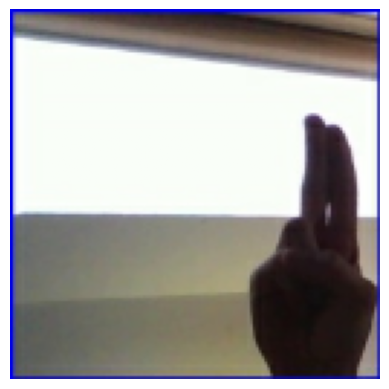

In [92]:
images = images / 255.0

plt.imshow(images[4])
plt.axis('off')
plt.show()

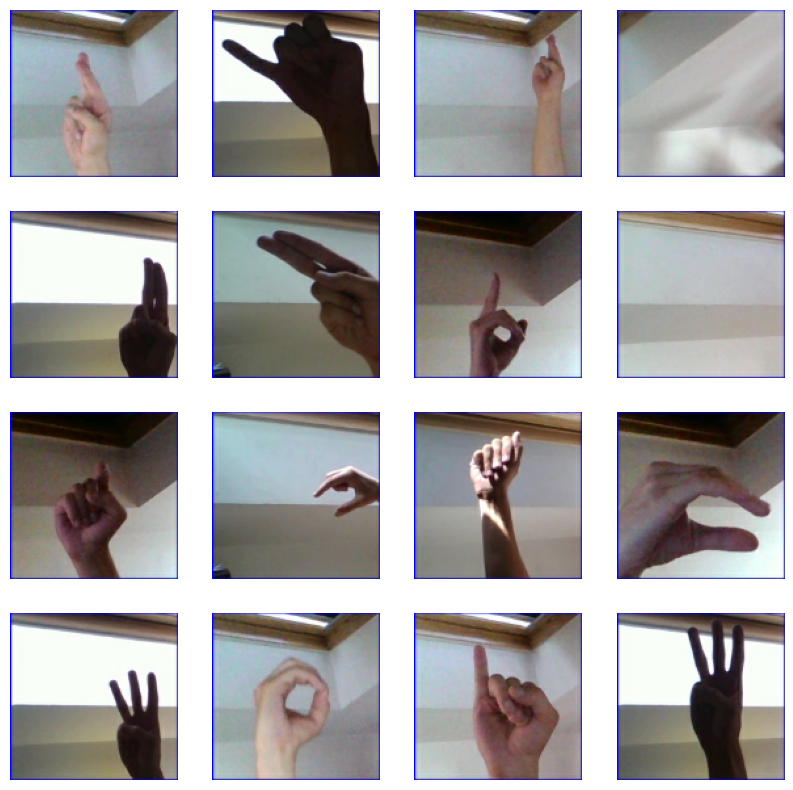

In [96]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i in range(4):
    for j in range(4):
        idx = i*4 + j
        axes[i, j].imshow(images[idx])
        axes[i, j].axis('off')

plt.show()

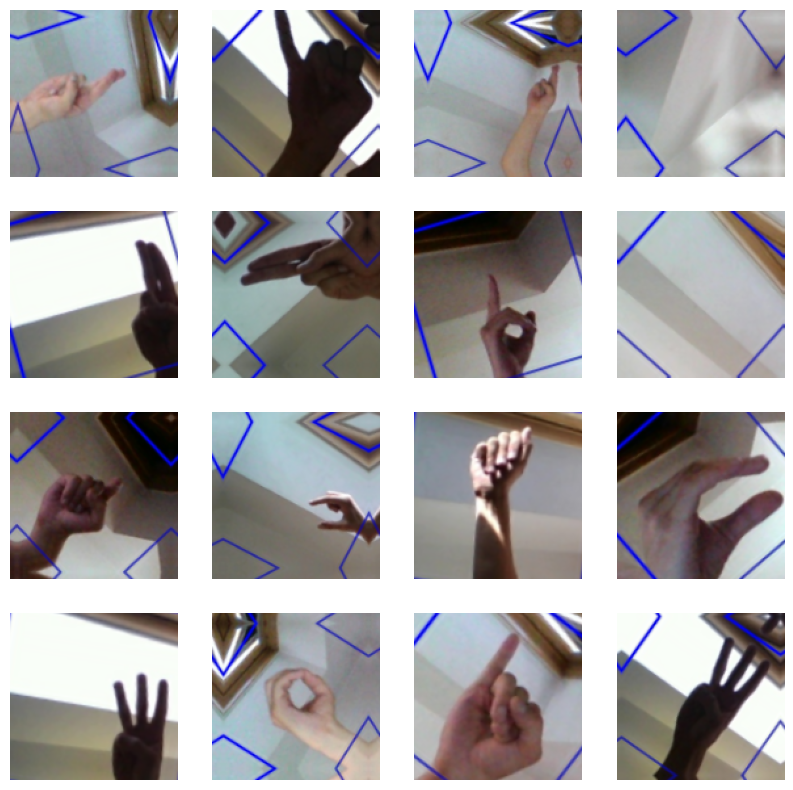

In [97]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i in range(4):
    for j in range(4):
        idx = i*4 + j
        axes[i, j].imshow(aug[idx])
        axes[i, j].axis('off')

plt.show()

In [100]:
num_classes = 29

def one_hot(x, y):
    y = tf.keras.utils.to_categorical(y, num_classes)
    return x, y

In [101]:
train_data = train_data.map(one_hot)
val_data = val_data.map(one_hot)